In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import rioxarray
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm.auto import tqdm
import copy
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


TODOs:
- Using Square images rather than masked ones
- 

In [2]:
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white

def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."

def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def label_csv_2(clean_img_path):
    #only for saturday and sunday
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        if find_day(date_string) == 'Saturday' or find_day(date_string) == 'Sunday':
            df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
            
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df

def create_median_image(images_path):

    first_img = rioxarray.open_rasterio(images_path[0])

    width, height = first_img.data[0:3].transpose(1, 2, 0).shape[0:2]
    num_images = len(images_path)

    red_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    green_values = np.zeros(( width,height, num_images), dtype=np.uint8)
    blue_values = np.zeros(( width,height, num_images), dtype=np.uint8)


    for i,j in enumerate(images_path):
        img = rioxarray.open_rasterio(j).data[0:3].transpose(1, 2, 0)
        try:
            red_values[:, :, i], green_values[:, :, i], blue_values[:, :, i] = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        except:
            pass
    
    red_median = np.median(red_values, axis=2)
    green_median = np.median(green_values, axis=2)
    blue_median = np.median(blue_values, axis=2)
    img_arr = np.uint8(np.dstack((red_median, green_median, blue_median)))
    median_image = Image.fromarray(img_arr)
    
    return img_arr, median_image

def extract_random_patches(image, patch_size=(20, 20), num_patches=10, threshold=50):
    patches = []
    image_height, image_width = image.shape[:2]
    patch_height, patch_width = patch_size

    
    while len(patches) < num_patches:
        # Generate random coordinates for the top-left corner of the patch
        start_h = np.random.randint(0, image_height - patch_height + 1)
        start_w = np.random.randint(0, image_width - patch_width + 1)
        
        # Extract the patch using slicing
        patch = image[start_h:start_h + patch_height, start_w:start_w + patch_width]
        if (patch == 0).sum()/(patch_height*patch_height*3) < threshold/100:  #removes black patches
            patches.append(patch)
        else:
            pass
    
    return patches


#### Individual parking lots

In [3]:
img_path = "/home/akansh-i2sc/Desktop/Project/detect-car-LR/data/data_parking_masked/Saarbrucken_Park/parking_lot_434_bbox/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

Initial size of dataset 500
Most common size of the dataset (4, 81, 68)
Final size of dataset(after removing faulty size images) 500
Final size of dataset(after removing faulty black pixels in images) 493
Final size of dataset(after removing faulty white pixels in images) 454


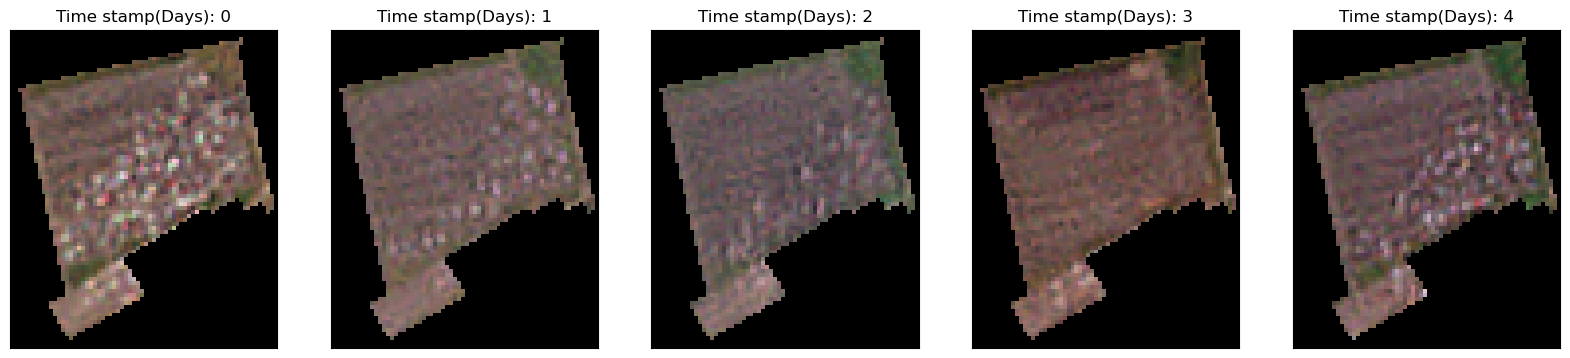

In [4]:
masked_clean = [i for i in clean_3 if 'Masked' in i]
square_clean = [i for i in clean_3 if 'Planet' in i]

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = rioxarray.open_rasterio(masked_clean[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.title(f'Time stamp(Days): {i}')
    plt.xticks([])
    plt.yticks([])

In [5]:
#Checking the dimensions of the images
img = rioxarray.open_rasterio(masked_clean[i])
img.data[0:3].transpose(1, 2, 0).shape

(81, 68, 3)

In [6]:
img = rioxarray.open_rasterio(masked_clean[0])
image = img.data[0:3].transpose(1, 2, 0)
random_patches = extract_random_patches(image, patch_size=(20, 20), num_patches=15)
print(len(random_patches))

15


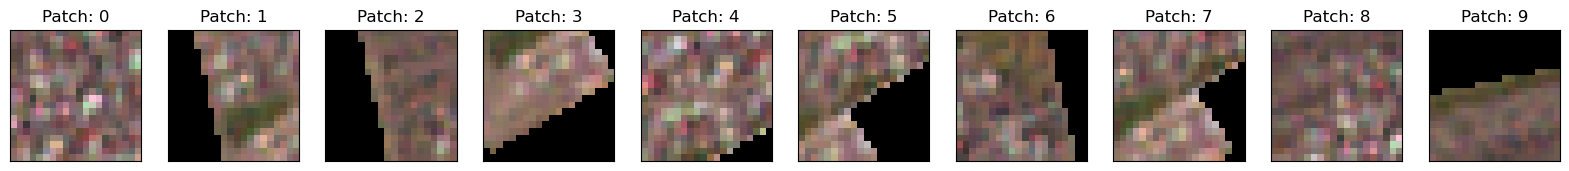

In [7]:
#plot these 10 random patches
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(random_patches[i])
    plt.title(f'Patch: {i}')
    plt.xticks([])
    plt.yticks([])

##### Method 1: Sunday vs others

In [8]:
#Creating labels for the dataset
df = label_csv(masked_clean)

Class distribution in dataset: 0    198
1     29
Name: label, dtype: int64


Training

In [9]:
class lr_car_detect_dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.image_path.values[idx]
        img = rioxarray.open_rasterio(img_path)
        img = img.data[0:3].transpose(1, 2, 0)
        random_patches = extract_random_patches(img, patch_size=(20, 20), num_patches=1)
        # print('random is runing')
        label = self.df.label.values[idx]        
        if self.transform:
            img = self.transform(random_patches[0])
        return img, label


##### Augmentations and transforms

In [10]:
# Custom function for Gaussian blur
# from PIL import ImageFilter
### Will implement later

# class GaussianBlur(object):
#     def __init__(self, kernel_size=3):
#         self.kernel_size = kernel_size

#     def __call__(self, tensor):
#         img = transforms.ToPILImage()(tensor)
#         img_blurred = img.filter(ImageFilter.GaussianBlur(self.kernel_size))
#         return transforms.ToTensor()(img_blurred)

# # Custom function for adding Gaussian noise
# class AddGaussianNoise(object):
#     def __init__(self, mean=0, std=0.1):
#         self.mean = mean
#         self.std = std

#     def __call__(self, tensor):
#         noise = torch.randn_like(tensor) * self.std + self.mean
#         noisy_tensor = tensor + noise
#         return noisy_tensor
# combined_transform = transforms.Compose([
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random Brightness/Contrast Adjustment
#     transforms.RandomRotation(degrees=45),  # Random Rotation
#     transforms.RandomHorizontalFlip(p=0.5),  # Horizontal Flipping
#     transforms.RandomVerticalFlip(p=0.5),  # Vertical Flipping
#     GaussianBlur(kernel_size=3),  # Gaussian Blur
#     AddGaussianNoise(mean=0, std=0.1),  # Addition of Gaussian Noise
#     # You can add other necessary transformations here
# ])



train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),])

In [11]:
#train test split
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())

Train size: (181, 3)
Test size: (46, 3)
Train class distribution: 0    158
1     23
Name: label, dtype: int64
Test class distribution: 0    40
1     6
Name: label, dtype: int64


In [16]:
train_dataset = lr_car_detect_dataset(train, transform=train_transform)
test_dataset = lr_car_detect_dataset(test, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(512, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [17]:
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss = []
    train_acc = []
    train_auc = []
    val_loss = []
    val_acc = []
    val_auc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            y_pred = []
            y_true = []
            # Iterate over data.
            for inputs, labels in eval(phase+'_loader'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
            epoch_loss = running_loss / len(eval(phase+'_loader').dataset)
            epoch_acc = running_corrects.double() / len(eval(phase+'_loader').dataset)
            epoch_auc = roc_auc_score(y_true, y_pred)
            print('{} Loss: {:.4f} Acc: {:.4f} AUC: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_auc))
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_auc.append(epoch_auc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                val_auc.append(epoch_auc)
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                # torch.save(model.state_dict(), '"patch_based_model_individial_parking.pt')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val AUC: {:4f}'.format(best_auc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc

In [18]:
model, train_loss, train_acc, val_loss, val_acc, train_auc, val_auc = train_model(model, criterion, optimizer, num_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
----------
train Loss: 0.6419 Acc: 0.7680 AUC: 0.5142
test Loss: 0.5079 Acc: 0.8913 AUC: 0.5833
Epoch 1/199
----------
train Loss: 0.6228 Acc: 0.8508 AUC: 0.4873
test Loss: 0.5705 Acc: 0.8696 AUC: 0.5000
Epoch 2/199
----------
train Loss: 0.4164 Acc: 0.8453 AUC: 0.5028
test Loss: 0.6888 Acc: 0.8696 AUC: 0.5708
Epoch 3/199
----------
train Loss: 0.4991 Acc: 0.8619 AUC: 0.4937
test Loss: 0.6202 Acc: 0.8478 AUC: 0.4875
Epoch 4/199
----------
train Loss: 0.5580 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4861 Acc: 0.8478 AUC: 0.4875
Epoch 5/199
----------
train Loss: 0.4262 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4015 Acc: 0.8696 AUC: 0.5000
Epoch 6/199
----------
train Loss: 0.4060 Acc: 0.8729 AUC: 0.5000
test Loss: 0.3832 Acc: 0.8696 AUC: 0.5000
Epoch 7/199
----------
train Loss: 0.4307 Acc: 0.8453 AUC: 0.4842
test Loss: 0.4452 Acc: 0.8696 AUC: 0.5000
Epoch 8/199
----------
train Loss: 0.3979 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4190 Acc: 0.8696 AUC: 0.5000
Epoch 9/199
----------
train

train Loss: 0.3754 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4075 Acc: 0.8696 AUC: 0.5000
Epoch 77/199
----------
train Loss: 0.3863 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4021 Acc: 0.8696 AUC: 0.5000
Epoch 78/199
----------
train Loss: 0.3981 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4263 Acc: 0.8696 AUC: 0.5000
Epoch 79/199
----------
train Loss: 0.3717 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4020 Acc: 0.8696 AUC: 0.5000
Epoch 80/199
----------
train Loss: 0.3845 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4050 Acc: 0.8696 AUC: 0.5000
Epoch 81/199
----------
train Loss: 0.4058 Acc: 0.8729 AUC: 0.5000
test Loss: 0.3832 Acc: 0.8696 AUC: 0.5000
Epoch 82/199
----------
train Loss: 0.3709 Acc: 0.8729 AUC: 0.5000
test Loss: 0.3822 Acc: 0.8696 AUC: 0.5000
Epoch 83/199
----------
train Loss: 0.3722 Acc: 0.8729 AUC: 0.5000
test Loss: 0.3949 Acc: 0.8696 AUC: 0.5000
Epoch 84/199
----------
train Loss: 0.3914 Acc: 0.8729 AUC: 0.5000
test Loss: 0.3906 Acc: 0.8696 AUC: 0.5000
Epoch 85/199
----------
train Loss: 0.3839 

train Loss: 0.3480 Acc: 0.8785 AUC: 0.5217
test Loss: 0.5306 Acc: 0.8696 AUC: 0.5000
Epoch 152/199
----------
train Loss: 0.3837 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4970 Acc: 0.8696 AUC: 0.5000
Epoch 153/199
----------
train Loss: 0.3732 Acc: 0.8729 AUC: 0.5000
test Loss: 0.5106 Acc: 0.8478 AUC: 0.4875
Epoch 154/199
----------
train Loss: 0.3690 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4369 Acc: 0.8696 AUC: 0.5000
Epoch 155/199
----------
train Loss: 0.3619 Acc: 0.8729 AUC: 0.5000
test Loss: 0.7035 Acc: 0.8696 AUC: 0.5000
Epoch 156/199
----------
train Loss: 0.3708 Acc: 0.8729 AUC: 0.5000
test Loss: 0.3857 Acc: 0.8696 AUC: 0.5000
Epoch 157/199
----------
train Loss: 0.3702 Acc: 0.8729 AUC: 0.5000
test Loss: 0.3820 Acc: 0.8696 AUC: 0.5000
Epoch 158/199
----------
train Loss: 0.3538 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4986 Acc: 0.8696 AUC: 0.5000
Epoch 159/199
----------
train Loss: 0.3563 Acc: 0.8729 AUC: 0.5000
test Loss: 0.4298 Acc: 0.8696 AUC: 0.5000
Epoch 160/199
----------
train Loss

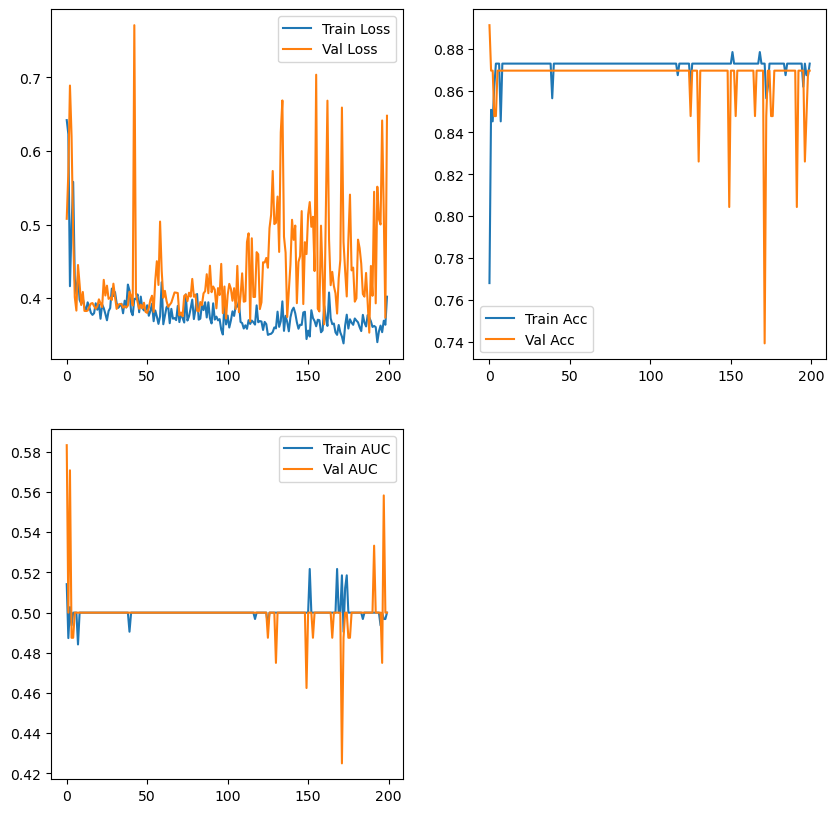

In [19]:
train_acc_values = []
for index in range(len(train_acc)):
    train_acc_values.append(train_acc[index].item())

val_acc_values = []
for index in range(len(val_acc)):
    val_acc_values.append(val_acc[index].item())

#plotting the loss and accuracy curves, AUC scores for train and test set
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(train_acc_values, label='Train Acc')
plt.plot(val_acc_values, label='Val Acc')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Val AUC')
plt.legend()
plt.show()

- Conclusion: Seems like this is not working

In [20]:
#Creating a big dataset of patches and doing only Saturday vs Sunday
df_2 = label_csv_2(masked_clean)

Class distribution in dataset: 1    29
0    26
Name: label, dtype: int64


55

#### Selecting 5 parking lots